## VAE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets
from torchsummary import summary

device = 'mps'

### Importing Data

In [2]:
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [3]:
print(f"Train:\n{train_data}")
print(f"\nTest:\n{test_data}")

Train:
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Test:
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


### Visualising Data

Shape of Image Tensor: torch.Size([1, 28, 28])
Label of Image: 7


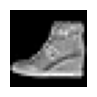

In [4]:
idx = torch.randint(0,60000,(1,)).item()
image, label = train_data[idx]
print(f'Shape of Image Tensor: {image.shape}')
print(f'Label of Image: {label}')

plt.figure(figsize = (1,1))
plt.imshow(image.squeeze(),cmap='gray')
plt.axis('off')
plt.show()

### Dataloader Iterator

In [5]:
size =32

train_loader = DataLoader(train_data, batch_size = size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = size, shuffle = False)

print(f'Train Loader\nlength: {len(train_loader)} batches of {size}\ntype: {type(train_loader)}')
print(f'\nTest\nlength: {len(test_loader)} batches of {size}\ntype: {type(test_loader)}')

Train Loader
length: 1875 batches of 32
type: <class 'torch.utils.data.dataloader.DataLoader'>

Test
length: 313 batches of 32
type: <class 'torch.utils.data.dataloader.DataLoader'>


### Model Architechture


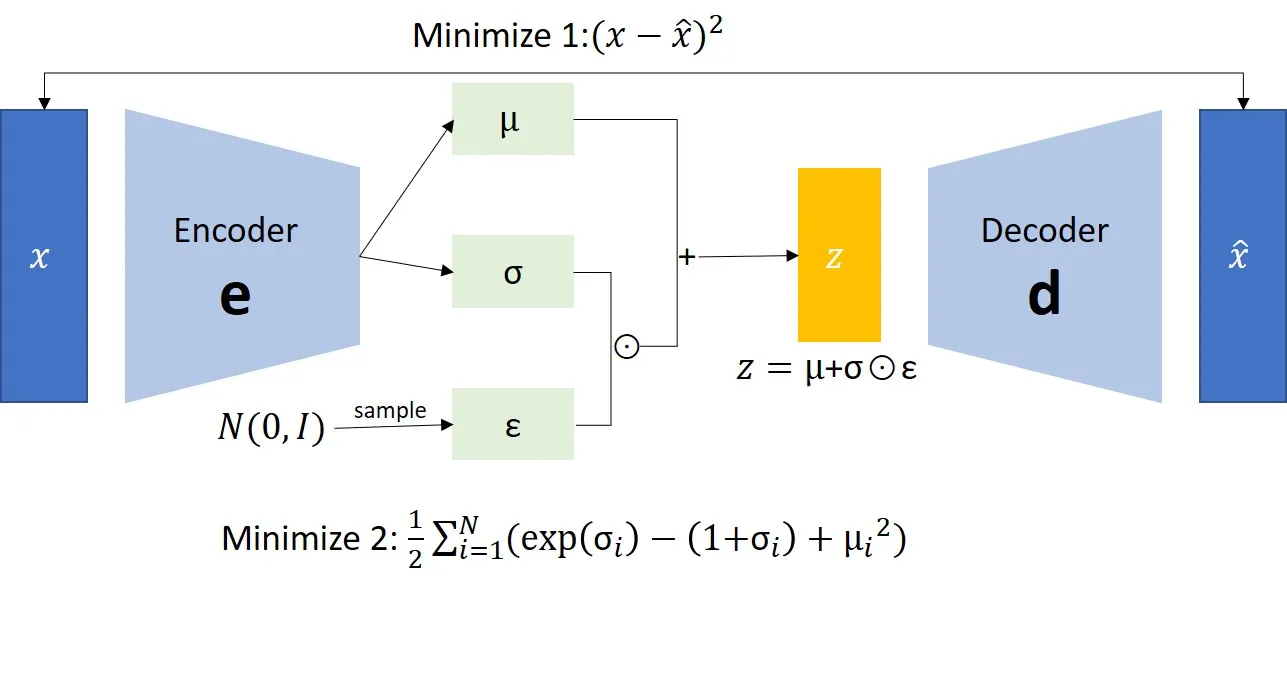

In [6]:
class ConvVAE(nn.Module):
    
    def __init__(self, latent_dim = 16):
        super().__init__()
        
        ##Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, padding='same'),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding='same'),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, padding='same'),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        
        ##Latent
        self.Latent_mean = nn.Linear(in_features = 1152, out_features=latent_dim)
        self.Latent_var = nn.Linear(in_features = 1152, out_features=latent_dim)
        
        ##Decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features = latent_dim, out_features=400),
            nn.Linear(in_features = 400, out_features = 4000),
            nn.Unflatten(1,(10,20,20)),
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size=5),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(in_channels = 10, out_channels = 1, kernel_size=5),
            nn.Sigmoid()
        )
        
    ##Reparameterization Trick
    def reparameterize(self, mean, logvar):
        epsilon = torch.randn_like(logvar)    
        z = mean + epsilon * torch.exp(logvar/2.)
        return z

    ##Encoder Function
    def encode(self,x):
        x = self.encoder(x)
        mean, logvar = self.Latent_mean(x), self.Latent_var(x)
        return mean, logvar

    ##Decoder Function
    def decode(self,x):
        x = self.decoder(x)
        return x


    def forward(self,x):
        x = x.to(device)
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_hat = self.decode(z)
        return x_hat,mean,logvar


### Defining Model

In [7]:
model = ConvVAE(latent_dim = 20)
model = model.to(device)
model

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (7): LeakyReLU(negative_slope=0.01)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (Latent_mean): Linear(in_features=1152, out_features=20, bias=True)
  (Latent_var): Linear(in_features=1152, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=4000, bias=True)
    (2): Unflatten(dim=1, unflattened_siz

In [8]:
summary(model, input_size=(1,28,28),batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 32, 28, 28]             832
         LeakyReLU-2           [32, 32, 28, 28]               0
         MaxPool2d-3           [32, 32, 14, 14]               0
            Conv2d-4           [32, 64, 14, 14]          51,264
         LeakyReLU-5           [32, 64, 14, 14]               0
         MaxPool2d-6             [32, 64, 7, 7]               0
            Conv2d-7            [32, 128, 7, 7]         204,928
         LeakyReLU-8            [32, 128, 7, 7]               0
         MaxPool2d-9            [32, 128, 3, 3]               0
          Flatten-10                 [32, 1152]               0
           Linear-11                   [32, 20]          23,060
           Linear-12                   [32, 20]          23,060
           Linear-13                  [32, 400]           8,400
           Linear-14                 [3

### Loss Function and Optimizer

In [9]:
def loss_fn(x_hat,x,mean,logvar):
    reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD_loss = -0.5* torch.sum(1+logvar - mean.pow(2) - logvar.exp())
    return reconstruction_loss + KLD_loss

optimizer = optim.Adam(model.parameters(),lr=0.001)

### Train the model

In [11]:
### Train the model

def train(model, epochs, dataloader, loss_fn=loss_fn, optimizer=optimizer, device='mps'):
    train_loss_list = []
    epoch_list = []
    model.train
    for epoch in range(epochs):
        train_loss = 0
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)
            output, mean, logvar = model(X)
            loss = loss_fn(output, X, mean, logvar)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = train_loss/len(dataloader)
        train_loss_list.append(train_loss)
        epoch_list.append(epoch)

        print(f'Epoch {epoch+1} | train loss = {train_loss}')
    return train_loss_list, epoch_list

In [12]:
epochs = 10
train_loss_list, epoch_list = train(model, epochs, train_loader)

Epoch 1 | train loss = 8354.774740104167
Epoch 2 | train loss = 7906.41138515625
Epoch 3 | train loss = 7839.90018671875
Epoch 4 | train loss = 7806.779361197917
Epoch 5 | train loss = 7781.586578385417
Epoch 6 | train loss = 7763.46804765625
Epoch 7 | train loss = 7751.238840885417
Epoch 8 | train loss = 7740.1118638020835
Epoch 9 | train loss = 7732.3888729166665
Epoch 10 | train loss = 7724.133824479167


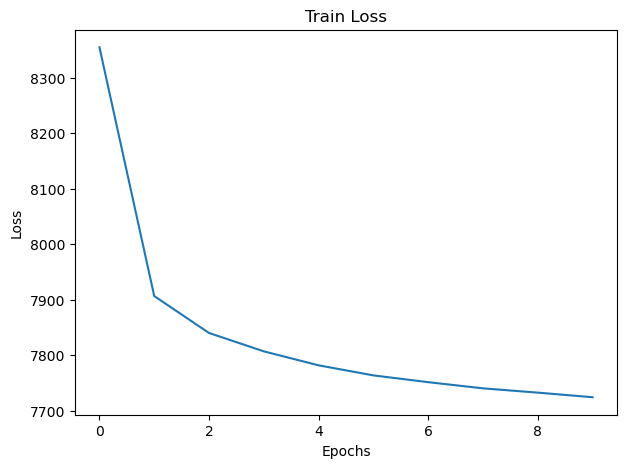

In [13]:
#train loss
plt.figure(figsize=(7,5))
plt.plot(epoch_list,train_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.show()

### Save Model

In [15]:
# Create models directory (if it doesn't already exist)
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "VAE_Fashion_MNIST"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)


Saving model to: models/VAE_Fashion_MNIST


### Load Model

In [16]:
model = ConvVAE(latent_dim = 20)

# Load in the saved state_dict()
model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
model = model.to(device)

### Generate Results

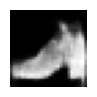

In [37]:
def generate():
    z_sample = torch.randn(20).to(device).unsqueeze(dim=1)
    x_decoded = model.decode(z_sample.T)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.figure(figsize=(1,1))
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate()